# Carbonate: Generate Core Calibrated Thin Sections and Pc Curves from normalized core data using KNN

### Introduction

###### This repository utilizes normalized core data with distance-weighted estimations for only the KNN samples being considered. This program queries a published carbonate core analysis database having Thomeer Capillary Pressure parameters and another with links to available Thin Sections to generate a widget showing both an estimated Capillary Pressure curve and representative Thin Sections for any reasonable user defined Porosity vs. Permeability combination for this particular reservoir. The results are based entirely on the core data being employed that represents this Arab D carbonate reservoir. This repository uses normalized core porosity and permeability data and the estimations based on KNN with Euclidean distances.

###### The objective of this core integration project is to generate representative Petrophysical data for user defined porosity and permeability combination based on the core reference data. Our reference data is an Arab D carbonate core analysis database from the Middle East as published by Clerke1. The core analysis database being queried has porosity and permeability as well as the Thomeer-based Capillary Pressure parameters, BVi, Pdi and Gi used with each pore system i. There is one other core database with links to available Thin Sections based on their poro-perm relationships. The image below shows the available Thin Section images and how they vary with porosity and permeability as shown on the Porosity vs. Permeability Cross Plot. This image illustrates the textural changes of the rock over poro-perm space.

###### 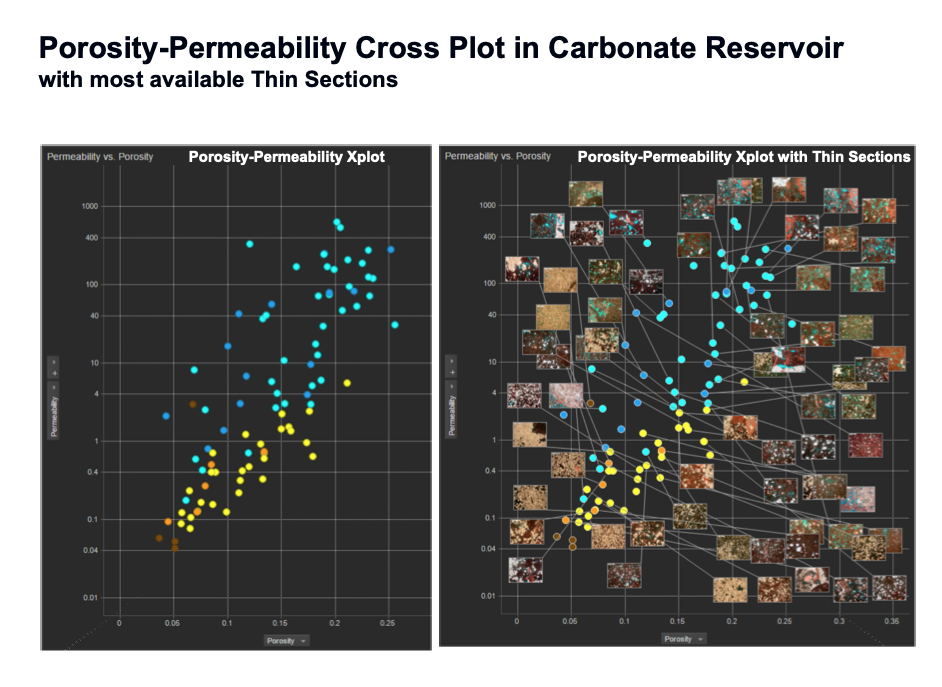

###### For this repository we are using the inverse of the Euclidean distances for normalized porosity and permeability data to generate the distance-weighted KNN Thomeer Capillary Pressure parameters or the nearest representative Thin Section image based on the normalized poro-perm relationships of the data. This process is based on the Euclidean distance difference between the normalized core analysis reference poro-perm data vs. the normalized user defined poro-perm combination and the inverse of the n nearest Euclidean distances are the only values being used for the distance-weighted averages.

###### 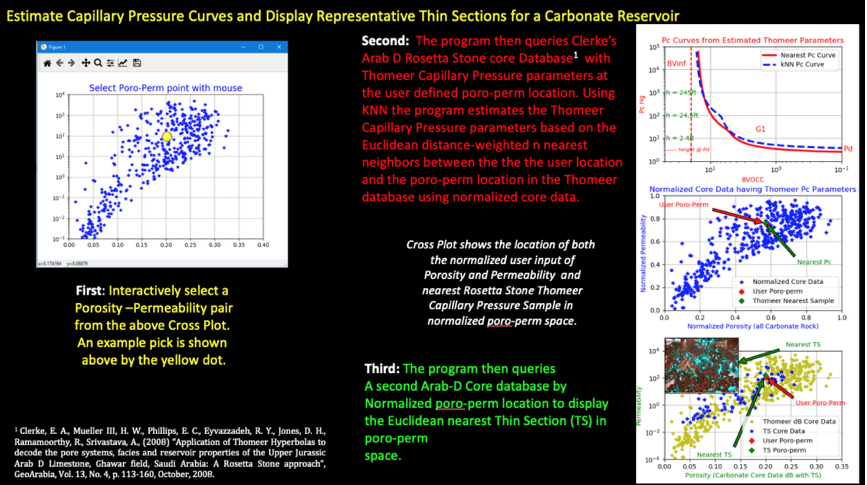

###### 1 Clerke, E. A., Mueller III, H. W., Phillips, E. C., Eyvazzadeh, R. Y., Jones, D. H., Ramamoorthy, R., Srivastava, A., (2008) “Application of Thomeer Hyperbolas to decode the pore systems, facies and reservoir properties of the Upper Jurassic Arab D Limestone, Ghawar field, Saudi Arabia: A Rosetta Stone approach”, GeoArabia, Vol. 13, No. 4, p. 113-160, October, 2008.

### Data:

###### Core Analysis Data with Thomeer Capillary Pressure Parameters (mapinv_reference_data_carbonates_calculatedMode_Rosetta.xls)

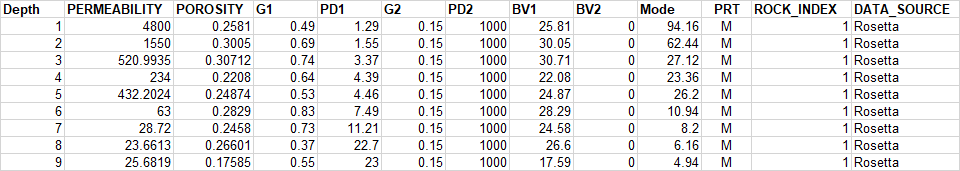

###### Core Analysis Data with Thin Sections (CO3_TS_Image.xls)

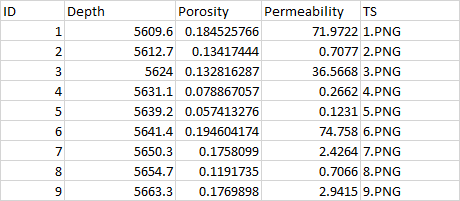

### Code:

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Tue Aug 27 09:50:53 2019

@author: craig
"""
#import sys

#from IPython import get_ipython
#get_ipython().magic('reset -sf')


import sys
from PyQt5.QtWidgets import QApplication, QMainWindow, QMenu, QVBoxLayout, QSizePolicy, QMessageBox, QWidget, QPushButton
from PyQt5.QtCore import QTimer
#******************************************************************
import matplotlib
#import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
matplotlib.use("Qt5Agg")
import matplotlib.gridspec as gridspec
#******************************************************************
from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg as FigureCanvas
from matplotlib.figure import Figure
#import matplotlib.pyplot as plt
import numpy as np
from numpy import diff
import math
import xlrd
from colorama import Fore, Style


###### Load Core Analsis Reference Data with Thomeer Parameters

In [2]:
# =============================================================================
# # ===========================================================================
# # #-------------------------------------------------------------------------- 
# # #                Read Reference Data Spreadsheet 
# # #  Read mapinv_reference_data_carbonates_calculatedMode_Rosetta data 
# # #                which is the Rosetta Stone reference data per Clerke
# # #--------------------------------------------------------------------------
# # ===========================================================================
# =============================================================================


book = xlrd.open_workbook("mapinv_reference_data_carbonates_calculatedMode_Rosetta.xls")  

print( "The number of worksheets is", book.nsheets)
#print( "Worksheet name(s):", book.sheet_names())
sh = book.sheet_by_index(0)
print(sh.name, sh.nrows, sh.ncols)

import win32com.client
o = win32com.client.Dispatch("Excel.Application")
#o.Visible = 1
#o.Workbooks.Add() # for office 97  95 a bit different!


# ---------------------------------------------------------------------------- 
#                  Initialize DATA 
# ----------------------------------------------------------------------------

Permeability = []
Porosity = []
G1 = []
PD1 = []
BV1 = []
G2 = []
PD2 = []
BV2 = []


# ------------------------------------------------------------------ 
#    read in maininv_reference2 data which is just Rosetta Stone 
#                     this is reference data
#                       DATA WILL BE LOADED
# ------------------------------------------------------------------


for i in range(0,sh.nrows,1):
        Permeability.append(sh.cell_value(rowx=i, colx=1))
        Porosity.append(sh.cell_value(rowx=i, colx=2))   #fraction
        G1.append(sh.cell_value(rowx=i, colx=3))
        PD1.append(sh.cell_value(rowx=i, colx=4))
        BV1.append(sh.cell_value(rowx=i, colx=7))
        G2.append(sh.cell_value(rowx=i, colx=5))
        PD2.append(sh.cell_value(rowx=i, colx=6))
        BV2.append(sh.cell_value(rowx=i, colx=8))
        


Perm_max = 4
Perm_min = -4
Por_max = .35
Por_min = 0


x4=np.array(Porosity)
y4=np.array(Permeability)


# =============================================================================
# # ===========================================================================
# # #------------------------------------------------------------ 
# # #               
# # #     End of reading in mapinv reference data
# # #------------------------------------------------------------
# # ===========================================================================
# =============================================================================


The number of worksheets is 1
main 444 13


###### Graphical Input (does not work in this Jupyter Notebook so hard code Por and Perm)

In [3]:
# =============================================================================
# # ===========================================================================
# # #--------------------------------------------------------------------------
# ##
# ##            Graphical Input of User Porosity and Pereability 
# ##
# # #--------------------------------------------------------------------------
# # ===========================================================================
# =============================================================================

def tellme(s):
    print(s)
    plt.title(s, fontsize=16, color = 'blue')
    plt.draw()



plt.clf()   #clear plot of other things
#tellme('You will define a triangle, click to begin')

plt.figure(1,figsize=(6, 5))
#plt.ion()
plt.semilogy(x4, y4  , 'b-*', linewidth=0, label='RSW Core Data' )
plt.xlim(0.0,.4)
plt.ylim(0.0001, 10000)
plt.grid(True)


#plt.waitforbuttonpress()

#Use pts array to store selected points
pts = []

"""
-------------------------------------------------------------------------------------------
# This has been removed for Jupyter Notebook
#while len(pts) < 1:
#    tellme('Select Poro-Perm point with mouse')
#    pts = np.asarray(plt.ginput(1, timeout=3))
#Por = pts.item(0)
#Perm = pts.item(1)
--------------------------------------------------------------------------------------------
"""
Por = .22
Perm = 456

print()
print('Porosity =', Por, ' and Permeability =', Perm)
print()



plt.close('all')  




Porosity = 0.22  and Permeability = 456



###### KNN

In [4]:
# =============================================================================
# # ===========================================================================
# # #--------------------------------------------------------------------------
# ##
# ##            This is the beginnin of KNN
# ##
# # #--------------------------------------------------------------------------
# # ===========================================================================
# =============================================================================

#Por = float(input('Input Porosity (fraction) = '))
#Perm = float(input('Input Permeability (mD) = '))

#normalized Porosity and Permeability inputs
por = (Por-Por_min)/(Por_max - Por_min)
perm= (math.log10(Perm) - Perm_min)/(Perm_max - Perm_min)





# =============================================================================
# #---------------------------------------------------------------------------- 
# #           
# #              ESTIMATE THOMEER PARAMETERS FOR BOTH PORE SYSTEMS
# #                   
# #----------------------------------------------------------------------------
# =============================================================================

dist_inv = []
dist_phi = []
dist_lperm = []
G1_weight = []
PD1_weight = []
BV1_weight = []
G2_weight = []
PD2_weight = []
BV2_weight = []



dist_inv_total=0
G1_total  = 0
PD1_total = 0
BV1_total = 0
G2_total  = 0
PD2_total = 0
BV2_total = 0




inv_dist_array = []
#distance_knn_array = [rows,columns]
distance_knn_array = []


#------------------------------------------------------------------ 
#               Estimate all Thomeer Parameters for *_est values
#-------------------------------------------------------------------

Porosity_norm     = []
Permeability_norm = []


#this is the mapinv_reference_data being used 
for i in range(0,sh.nrows,1):

        Porosity_norm.append((Porosity[i] - Por_min) / (Por_max - Por_min))
        Permeability_norm.append((math.log10(Permeability[i]) - Perm_min) / (Perm_max - Perm_min))
        
        #Euclidian Distance
        dist_phi.append(   abs(por  - Porosity_norm[i]    ))  
        dist_lperm.append( abs(perm - Permeability_norm[i]))
        dist_inv.append( 1  /  math.sqrt(  dist_phi[i]**2 + dist_lperm[i]**2)  )

        
        #calculalte weights for each
        G1_weight.append(dist_inv[i]  * G1[i])
        PD1_weight.append(dist_inv[i] * PD1[i])
        BV1_weight.append(dist_inv[i] * BV1[i])
        G2_weight.append(dist_inv[i]  * G2[i])
        PD2_weight.append(dist_inv[i] * PD2[i])
        BV2_weight.append(dist_inv[i] * BV2[i])
        


        inv_dist_array.append(dist_inv[i]);  # add items

# =============================================================================
###                    KNN Array
# # ===========================================================================
# # #--------------------------------------------------------------------------
        distance_knn_array = [dist_inv, G1_weight, PD1_weight, BV1_weight, G2_weight, PD2_weight, BV2_weight]
#        distance_knn_array = [Permeability, Porosity, G1, PD1, BV1, G2, PD2, BV2]
# # #--------------------------------------------------------------------------
# # ===========================================================================
# =============================================================================
xnorm=np.array(Porosity_norm)
ynorm=np.array(Permeability_norm)


# =============================================================================
# # ===========================================================================
# # #--------------------------------------------------------------------------
# # #           
# # #               Transpose and Sort new kNN array
# # #                   
# # #--------------------------------------------------------------------------
# # ===========================================================================
# =============================================================================

#knn_array = np.transpose array
knn_array = np.transpose(distance_knn_array)
#print(knn_array)

#Sort array from large to low by column 0 which is dist_inv 
#xknn=np.array(knn_array)

#matsor x[x[:,column].argsort()[::-1]] and -1 us reverse order
mat_sort = knn_array[knn_array[:,0].argsort()[::-1]] #firt column reverse sort (-1)
#mat_sort = x[x[:,1].argsort()[::-1]]
#mat_sort = x[x[:,2].argsort()[::-1]]


###### Estimate Thomeer Parameters

In [5]:
# =============================================================================
# # ===========================================================================
# # #--------------------------------------------------------------------------
# # #           
# # #               Calculate knn Thomeer Parameters
# # #                   
# # #--------------------------------------------------------------------------
# # ===========================================================================
# =============================================================================


#------------------------------------------------------------------------------
#    Number of nearest Neighbors
#------------------------------------------------------------------------------
n_neighbors = 3
#------------------------------------------------------------------------------

dist_inv_total_knn = 0
G1_total_knn = 0
PD1_total_knn = 0
BV1_total_knn = 0
G2_total_knn = 0
PD2_total_knn = 0
BV2_total_knn = 0




#kNN Estimates for first 3 rows
#dist_inv_total = mat_sort[0][0] + mat_sort[1][0] + mat_sort[2][0]
for i in range(0,n_neighbors,1):
    dist_inv_total_knn = dist_inv_total_knn + mat_sort[i][0]
    G1_total_knn  = G1_total_knn + mat_sort[i][1]
    PD1_total_knn = PD1_total_knn + mat_sort[i][2]
    BV1_total_knn = BV1_total_knn + mat_sort[i][3]
    G2_total_knn  = G2_total_knn + mat_sort[i][4]
    PD2_total_knn = PD2_total_knn + mat_sort[i][5]
    BV2_total_knn = BV2_total_knn + mat_sort[i][6]


#back to k values and calculate estimations now
G1_est_knn  = G1_total_knn  / dist_inv_total_knn
PD1_est_knn = PD1_total_knn / dist_inv_total_knn
BV1_est_knn = (BV1_total_knn / dist_inv_total_knn)
G2_est_knn  = G2_total_knn  / dist_inv_total_knn
PD2_est_knn = PD2_total_knn / dist_inv_total_knn
BV2_est_knn = (BV2_total_knn / dist_inv_total_knn)


print()
print(Fore.GREEN +'Estimated Thomeer Parameters from KNN =',n_neighbors,' on normlalized Poro-Perm data')
print(Fore.GREEN + '     G1 =',G1_est_knn, ',  Pd1 =',PD1_est_knn, ', BV1(%) =',BV1_est_knn) 
print(Fore.GREEN + '     G2 =',G2_est_knn, ',  Pd2 =',PD2_est_knn, ', BV2(%) =',BV2_est_knn) 
#print(Style.RESET_ALL) 
#print('back to normal now') 



Estimated Thomeer Parameters from KNN = 3  on normlalized Poro-Perm data
     G1 = 0.6314532491160246 ,  Pd1 = 2.8269322359660505 , BV1(%) = 18.110425329590672
     G2 = 0.09475002559079088 ,  Pd2 = 497.6323331680157 , BV2(%) = 3.5334756620767473


###### This section calculates the Pc curve from the KNN Estimated Thomeer parameters

In [6]:
# =============================================================================
# # ===========================================================================
# # #--------------------------------------------------------------------------
# # #           
# # #               CREATE Pc PLOTS from kNN Values of Thomeer
# # #                   
# # #--------------------------------------------------------------------------
# # ===========================================================================
# =============================================================================

Pc = 0.5
bvarray = []; #make list of 0 length
pcarray = []

   

for j in range(1, 105, 1):
    if Pc > PD1_est_knn:
        BVOCC1 = BV1_est_knn * 10**((-0.434 * G1_est_knn) / math.log10(Pc / PD1_est_knn))
    else:
        BVOCC1 = 0.001

    if Pc > PD2_est_knn:
        BVOCC2 = BV2_est_knn * 10 ** ((-0.434 * G2_est_knn) / math.log10(Pc / PD2_est_knn))
    else:
        BVOCC2 = 0.001

       
    BVOCC = BVOCC1 + BVOCC2
    
    bvarray.append(BVOCC); #add items 
    pcarray.append(Pc); #add items 
    
    Pc = Pc * 1.12

   
x5=np.array(bvarray)
y5=np.array(pcarray)


###### This section finds the closest Capillary Pressure curve in Poro-Perm space

In [7]:
# =============================================================================
# # ===========================================================================
# # #--------------------------------------------------------------------------
# # #           
# # #               Find Closest distance Pc curve in poro-perm space
# # #--------------------------------------------------------------------------
# # ===========================================================================
# =============================================================================

a = np.array(inv_dist_array)
inv_dist_thresh = np.percentile(a, 99.999)
print()
#print("Inv Distance Threshold =", inv_dist_thresh)
#print()


for i in range(0, sh.nrows, 1):
    if dist_inv[i] > inv_dist_thresh - 0.001:
        G_1 = G1[i]
        Pd1 = PD1[i]
        Bv1 = BV1[i]
        G_2 = G2[i]
        Pd2 = PD2[i]
        Bv2 = BV2[i]
        Perm_r = Permeability[i]
        Por_r = Porosity[i]
        mode_r = math.exp(-1.15*G_1)*(214/Pd1)

        Por_r_norm = (Por_r - Por_min)/(Por_max - Por_min)
        Perm_r_norm= (math.log10(Perm_r) - Perm_min)/(Perm_max - Perm_min)

#os.system("color 1") # colour can be any number between 1 to 8
print(Fore.RED +  'Thomeer Parameters Reference Set: Por_r =', Por_r,', Perm_r =', Perm_r)
print('     Pd1_r =',Pd1, '          , G1_r =',G_1, '            , BV1_r =',Bv1) 
print('     Pd2_r =',Pd2, '         , G2_r =',G_2, '            , BV2_r =',Bv2) 
#print('     Mode of PTD = ',mode_r , 'microns') 




Pc2 = 0.5
bvarray2 = []; #make list of 0 length
pcarray2 = []

for j in range(1, 105, 1):
    if Pc2 > Pd1:
        BVOCC11 = Bv1 * 10**((-0.434 * G_1) / math.log10(Pc2 / Pd1))
    else:
        BVOCC11 = 0.001

    if Pc2 > Pd2:
        BVOCC22 = Bv2 * 10 ** ((-0.434 * G_2) / math.log10(Pc2 / Pd2))
    else:
        BVOCC22 = 0.001

       
    BVOCC_r = BVOCC11 + BVOCC22
    
    bvarray2.append(BVOCC_r); #add items 
    pcarray2.append(Pc2); #add items 
    
    Pc2 = Pc2 * 1.12

   
x2=np.array(bvarray2)
y2=np.array(pcarray2)



Thomeer Parameters Reference Set: Por_r = 0.2223 , Perm_r = 498.0
     Pd1_r = 3.63           , G1_r = 0.5             , BV1_r = 17.74
     Pd2_r = 260.0          , G2_r = 0.1             , BV2_r = 4.01


###### This next section will generate a representative Thin Section image for the nearest sample in Poro-Perm space from what the user has selected

In [8]:
# =============================================================================
# # ===========================================================================
# # #-------------------------------------------------------------------------- 
# # #                Read Thin Section Spreadsheet
# # #  Read CO3 thin Section data which is Arab D Carbonate Data like Rosetta Stone data
# # #--------------------------------------------------------------------------
# # ===========================================================================
# =============================================================================




print()
print(Fore.GREEN + "Representative Thin Section:")
#print()

book = xlrd.open_workbook("CO3_TS_Image.xls")   #mapinv_reference cleaned up of obscure tri-modal samples
#print( "The number of worksheets is", book.nsheets)
#print( "Worksheet name(s):", book.sheet_names())
sh = book.sheet_by_index(0)
#print(sh.name, sh.nrows, sh.ncols)
#print()

import win32com.client
o = win32com.client.Dispatch("Excel.Application")
#o.Visible = 1
#o.Workbooks.Add() # for office 97  95 a bit different!
    

Depth = []
Porosity_TS = []
Permeability_TS = []
Path_TS = []
TS= False

  
for i in range(0,sh.nrows,1):
        Depth.append(sh.cell_value(rowx=i, colx=1))
        Porosity_TS.append(sh.cell_value(rowx=i, colx=2))
        Permeability_TS.append(sh.cell_value(rowx=i, colx=3))
        Path_TS.append(sh.cell_value(rowx=i, colx=4))
       
x3=np.array(Porosity_TS)
y3=np.array(Permeability_TS)



   
# =============================================================================
# # ===========================================================================
# ##
# ##                   Inverse Distance for TS 
# ##
# # ===========================================================================
# =============================================================================




dist_inv = []
dist_phi = []
dist_lperm = []
inv_dist_array2 = []
dist_inv_total=0



#------------------------------------------------------------------------------ 
#          Estimate Inv Distance data
#------------------------------------------------------------------------------

Porosity_norm_ts     = []
Permeability_norm_ts = []

#this is the mapinv_reference_data being used using the mapinv Porosity and Permeability vs. por and perm
for i in range(0,sh.nrows,1):

        Porosity_norm_ts.append((Porosity_TS[i] - Por_min) / (Por_max - Por_min))
        Permeability_norm_ts.append((math.log10(Permeability_TS[i]) - Perm_min) / (Perm_max - Perm_min))

        #Euclidian Distance
        dist_phi.append(   abs(por  - Porosity_norm_ts[i]    ))  
        dist_lperm.append( abs(perm - Permeability_norm_ts[i]))
        dist_inv.append( 1  /  math.sqrt(  dist_phi[i]**2 + dist_lperm[i]**2)  )


        inv_dist_array2.append(dist_inv);  # add items


a = np.array(inv_dist_array2) 
inv_dist_thresh = np.percentile(a, 99.999)


#plt.figure(2)        
for p in range(0,sh.nrows ,1):        
        if dist_inv[p] > inv_dist_thresh - 0.001 and dist_inv[p] > 0.001:
            TS = Path_TS[p]
            Por_TS = Porosity_TS[p]
            Perm_TS = Permeability_TS[p]
       

#            print("     Reference Data: Porosity =",Porosity[p], ", Permeability =", Permeability[p],", Inv Dist '",dist_inv[i],TS)
            print(Fore.GREEN +"     Porosity =",Porosity_TS[p], ", Permeability =", Permeability_TS[p])
            print(Fore.GREEN +"     Inv Dist '",dist_inv[p],", TS Image =", Path_TS[p])    
            img=mpimg.imread(TS)
#            imgplot = plt.imshow(img)
#            plt.show()
#        else:
#            TS = 'blank.PNG'
#            Por_TS = 0
#            Perm_TS = 0
#            img=mpimg.imread(TS)               

if not TS :
    print("     'No Representative Thin Section'")
    TS = 'blank.PNG'
    Por_TS = 0
    Perm_TS = 0
    img=mpimg.imread(TS)               
    
else:
    print(Fore.GREEN + "     Representative Thin Section is Available")
       
print(Style.RESET_ALL) 

plt.close('all')
quit



Representative Thin Section:
     Porosity = 0.230983261194418 , Permeability = 274.608
     Inv Dist ' 23.954364342489367 , TS Image = 84.PNG
     Representative Thin Section is Available



###### Plot Widget

In [ ]:
# =============================================================================
# # ===========================================================================
# # #-------------------------------------------------------------------------- 
# # #                
# # #               Qt GUI Plots made here
# # #--------------------------------------------------------------------------
# # ===========================================================================
# =============================================================================

#Define Canvas
class App(QMainWindow):

    def __init__(self):
        super().__init__()
        self.left = 50
        self.top = 100
        self.title = 'Carbonate Petrophysical Analysis'
        self.width = 500
        self.height = 1200
        self.initUI()




    #Define Canvas and Pushbutton
    def initUI(self):
        self.setWindowTitle(self.title)
        self.setGeometry(self.left, self.top, self.width, self.height)

        # this defines the width and height of canvas 
        m = PlotCanvas(self, width=5, height=12)
        m.move(0,0)



        button = QPushButton('Quit Window', self)
        button.setDefault(True)
        button.setToolTip('Push this button to quit')
        #Botton starts at 500 and 0
        button.move(400,0)
        #Botton starts at 500 and goes +140 to 640 to cover canvas
        button.resize(100,30)

#        def on_button_clicked():
#            alert = QMessageBox()
#            alert.setText('You clicked the button!')
#            alert.exec_()
        def on_button_clicked():
            sys.exit(app.exec_())



        button.clicked.connect(on_button_clicked)


        self.show()


class PlotCanvas(FigureCanvas):

#what is this???
    def __init__(self, parent=None, width=5, height=4, dpi=100):
        fig = Figure(figsize=(width, height), dpi=dpi)
#            self.axes = fig.add_subplot(211)  apparently not needed now

        FigureCanvas.__init__(self, fig)
        self.setParent(parent)

        FigureCanvas.setSizePolicy(self,
                QSizePolicy.Expanding,
                QSizePolicy.Expanding)
        FigureCanvas.updateGeometry(self)
        
        self.plot()
        self.plot2()
        self.plot3()
        self.plot4()


# Pc Plot across top 0 to 3
    def plot(self):

        gs = gridspec.GridSpec(nrows=3, 
                               ncols=3, 
#                               figure=fig, 
                               width_ratios= [1, 1, 1],
                               height_ratios=[1, 1, 1],
                               wspace=0.3,
                               hspace=0.3)
#wspace = 0.2   # the amount of width reserved for blank space between subplots
#hspace = 0.2   # the amount of height reserved for white space between subplots 

       
#        ax = self.figure.add_subplot(411) 
        ax = self.figure.add_subplot(gs[0, 0:3]) 
        
        
#        ax.subplots_adjust(hspace=0.4, wspace=0.4)
        
#        ax.loglog(x, y  , 'g--' , linewidth=3 , label='Inv Dist Weighted Pc Curve' )
        ax.loglog(x2, y2, 'r-'  , linewidth=3 , label='Nearest Pc Curve')
        ax.loglog(x5, y5, 'b--' , linewidth=3 , label='kNN Pc Curve')
        ax.set_xlim(50, 0.1)
        #ax.gca().invert_xaxis()
        ax.set_ylim(1, 100000)
        ax.set_title("Pc Curves from Estimated Thomeer Parameters", color = 'red')            
        ax.set_ylabel('Pc Hg', color = 'red')
        ax.set_xlabel('BVOCC', color = 'red')
        ax.grid(True)
        ax.legend()

        ax.text(50,8,' h = 2.4ft',horizontalalignment='left', fontsize=10, color='green')
        ax.text(50,80,' h = 24.5ft',horizontalalignment='left', fontsize=10, color='green')
        ax.text(50,800,' h = 245ft',horizontalalignment='left', fontsize=10, color='green') 
        ax.text(50,PD1_est_knn,'------- height @ Pd',horizontalalignment='left', fontsize=8, color='red', fontstyle='italic') 
#        ax.text(50,9000,' h = 4544ft',horizontalalignment='left')       

        ax.text(.1,PD1_est_knn,' Pd',horizontalalignment='left', fontsize=11, color='red')
        ax.text(max(diff(x5)) + 1,    PD1_est_knn + 6*PD1_est_knn,'    G1',horizontalalignment='right', fontsize=11, color='red')
        ax.text(BV1_est_knn + BV2_est_knn +4,  14000,'  BVinf',horizontalalignment='right', fontsize=11, color='red')
        ax.axvline(x= BV1_est_knn + BV2_est_knn, color='red' , linestyle='--')  #vertical line        
#        ax.annotate('Pd', fontsize=10, color='green', xy=(.1, PD1_est), xytext=(.5, 2),
#            arrowprops=dict(facecolor='green', shrink=0.01),
#            )
#        ax.annotate('BVinf', fontsize=10, color='green', xy=(BV1_est+BV2_est, 10000), xytext=(60,10000),
#            arrowprops=dict(facecolor='green', shrink=0.01),
#            )
#        ax.annotate('G1', fontsize=10, color='green', xy=(1, 100), xytext=(1,100),
##            arrowprops=dict(facecolor='green', shrink=1),
#            )


 
        self.draw()


#Poro_Perm xplot Thomeer Clastics dB
    def plot2(self):

        gs = gridspec.GridSpec(nrows=3, 
                               ncols=3, 
#                               figure=fig, 
                               width_ratios= [1, 1, 1],
                               height_ratios=[1, 1, 1],
                               wspace=0.3,
                               hspace=0.3)
        
        cx = self.figure.add_subplot(gs[1,0:3])        
        
        #cx = self.figure.add_subplot(412) 

        cx.plot(xnorm, ynorm  , 'b-*', linewidth=0, label='Normalized Core Data' )
        cx.plot(por, perm  , 'r-D', linewidth=0, label='User Poro-perm' )
        cx.plot(Por_r_norm, Perm_r_norm  , 'g-D', linewidth=0, label='Thomeer Nearest Sample ' )
#        cx.semilogy(Por_TS, Perm_TS  , 'c-^', linewidth=0, label='TS Poro-perm Point' )
        cx.set_xlim(0 , 1.0)
        #ax.gca().invert_xaxis()
        cx.set_ylim(0 , 1.0)
        cx.set_title("Normalized Core Data having Thomeer Pc Parameters", color = 'blue')            
        cx.set_ylabel('Normalized Permeability', color = 'blue')
        cx.set_xlabel('Normalized Porosity (all Carbonate Rock)', color = 'blue')
        cx.annotate('User Poro-Perm', fontsize=10, color='red', xy=(por, perm), xytext=(-0.03, 0.9),
                    arrowprops=dict(facecolor='red', shrink=0.05),
                    )
        cx.annotate('Nearest Pc', fontsize=10, color='green' ,xy=(Por_r_norm, Perm_r_norm), xytext=(0.75, .4),
                    arrowprops=dict(facecolor='green', shrink=0.05),
                    )



        cx.grid(True)
        cx.legend()

        self.draw()


#Poro_Perm xplot of Katmai Core data
    def plot3(self):

#wspace = 0.2   # the amount of width reserved for blank space between subplots
#hspace = 0.2   # the amount of height reserved for white space between subplots         
        
        gs = gridspec.GridSpec(nrows=3, 
                               ncols=3, 
#                               figure=fig, 
                               width_ratios= [1, 1, 1],
                               height_ratios=[1, 1, 1],
                               wspace=0.0,
                               hspace=0.4)
        
        cx = self.figure.add_subplot(gs[2,0:3])        
        #cx = self.figure.add_subplot(414) 
        cx.semilogy(x4, y4  , 'y-*', linewidth=0, label='Thomeer dB Core Data' )
        cx.semilogy(x3, y3  , 'b-*', linewidth=0, label='TS Core Data' )
        cx.semilogy(Por, Perm  , 'r-D', linewidth=0, label='User Poro-perm ' )
        cx.semilogy(Por_TS, Perm_TS  , 'g-D', linewidth=0, label='TS Poro-perm ' )
        cx.set_xlim(0.0,0.35)
        #ax.gca().invert_xaxis()
        cx.set_ylim(0.0001, 10000)
        #cx.set_title("Katmai Core Analysis Database")            
        cx.set_ylabel('Permeability', color='green')
        cx.set_xlabel('Porosity (Carbonate Core Data dB with TS)', color = 'green')
        cx.grid(True)
        cx.annotate('User Poro-Perm', fontsize=10, color='red', xy=(Por, Perm), xytext=(.26, 1),
                    arrowprops=dict(facecolor='red', shrink=0.05),
                    )
        cx.annotate('Nearest TS', fontsize=10, color='green' ,xy=(Por_TS, Perm_TS), xytext=(.065, 0.00015),
                    arrowprops=dict(facecolor='green', shrink=0.05),
                    )

        cx.annotate('Nearest TS', fontsize=10, color='green' , xy=(0.135, 1000), xytext=(.24, 20000),
                    arrowprops=dict(facecolor='green', shrink=0.1),
                    )


        cx.legend()

        self.draw()



#Thin Section plot row 1 and column 0
    def plot4(self):

#wspace = 0.2   # the amount of width reserved for blank space between subplots
#hspace = 0.2   # the amount of height reserved for white space between subplots         
        
        gs = gridspec.GridSpec(nrows=3, 
                               ncols=3, 
#                               figure=fig, 
                               width_ratios= [1, 1, 1],
                               height_ratios=[1, 1, 1],
                               wspace=-0.3,
                               hspace=-0.4)
        
        bx = self.figure.add_subplot(gs[2,0:1]) 

        bx.axes.get_xaxis().set_visible(False)
        bx.axes.get_yaxis().set_visible(False)

        bx.imshow(img)

        self.draw()


if __name__ == '__main__':
    app = QApplication(sys.argv)
    ex = App()
    sys.exit(app.exec_())
    